In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


df= pd.read_csv("zameen.csv")

In [2]:

# Step 2: Drop irrelevant columns
df.drop(columns=['agency', 'agent', 'page_url', 'property_id'], inplace=True, errors='ignore')
df.head()

,location_id,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,Area Type,Area Size,Area Category
0,3325,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,02-04-2019,Marla,4.0,0-5 Marla
1,3236,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,05-04-2019,Marla,5.6,5-10 Marla
2,764,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,07-17-2019,Marla,8.0,5-10 Marla
3,340,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,04-05-2019,Kanal,2.0,1-5 Kanal
4,3226,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Marla,8.0,5-10 Marla


In [3]:

# Step 3: Clean 'date_added'
df = df[~df['date_added'].astype(str).str.contains('#')]  # remove '########'
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df.dropna(subset=['date_added'], inplace=True)

In [4]:

# Step 4: Extract date features
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day
df.drop(columns=['date_added'], inplace=True)

In [5]:
# Step 5: Convert Area Type + Size into total_area_marla
def convert_to_marla(size, unit):
    if pd.isna(size) or pd.isna(unit):
        return None
    unit = str(unit).strip().lower()
    try:
        size = float(size)
    except:
        return None

    if unit == "marla":
        return size
    elif unit == "kanal":
        return size * 20
    elif unit in ["sq. yards", "square yards"]:
        return size / 30.25
    elif unit in ["sq. ft.", "square feet"]:
        return size / 225
    else:
        return None

In [6]:
# use log for target when prices , salary are highly skewed to normalize the distribution
df['total_area_marla'] = df.apply(lambda row: convert_to_marla(row['Area Size'], row['Area Type']), axis=1)
df.drop(columns=['Area Size', 'Area Type', 'area', 'Area Category'], inplace=True, errors='ignore')
df.dropna(subset=['total_area_marla'], inplace=True)
df.drop(columns=['location_id'], inplace=True, errors='ignore')

In [7]:
# Step 6: Encode categorical variables
cat_cols = ['property_type', 'location', 'city', 'province_name', 'purpose']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [8]:
# Step 7: Feature & target split
X = df.drop(columns=['price'])
y = np.log1p(df['price'])  # log (price + 1)

In [9]:

# Step 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:

# Step 9: Train model
n_estimators = 100
max_depth = 12
min_samples_leaf = 3

model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Step 10: Predict & evaluate
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {mse**0.5:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.15
Root Mean Squared Error: 0.38
R² Score: 0.9797


In [12]:
# Step 11: Feature importance plot
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

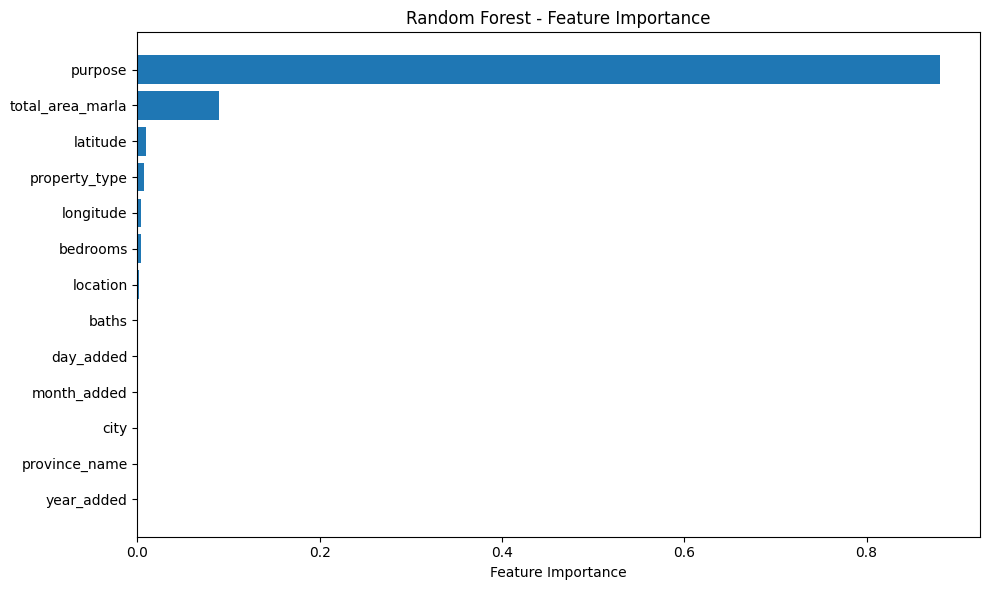

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

feature_order = X.columns.tolist()  # Keep the feature order
joblib.dump((model, feature_order),'price_model.pkl')
print("✅ Compressed model saved successfully!")

# model = joblib.load('price_model.pkl')
# print("✅ Model loaded successfully")

✅ Compressed model saved successfully!
✅ Model loaded successfully
